# 

# Part A

In [ ]:
# Install required packages
!pip install wandb pytorch-lightning

In [ ]:
# Import necessary libraries
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import wandb
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
class CustomCNN(LightningModule):
    def __init__(self, 
                 num_classes=10,
                 filter_counts=[32, 32, 64, 64, 128],
                 filter_sizes=[3, 3, 3, 3, 3],
                 activation='relu',
                 dense_neurons=512,
                 input_channels=3,
                 input_size=244,
                 dropout_rate=0.5,
                 learning_rate=0.001,
                 batch_norm=False):
        """
        Custom CNN architecture with flexible hyperparameters
        
        Args:
            num_classes (int): Number of output classes
            filter_counts (list): Number of filters in each conv layer
            filter_sizes (list): Size of filters in each conv layer
            activation (str): Activation function ('relu', 'gelu', 'silu', 'mish')
            dense_neurons (int): Number of neurons in the dense layer
            input_channels (int): Number of input channels (3 for RGB)
            input_size (int): Size of input images (assumes square)
            dropout_rate (float): Dropout rate
            learning_rate (float): Learning rate for optimizer
            batch_norm (bool): Whether to use batch normalization
        """
        super().__init__()
        self.save_hyperparameters()
        
        # Configure activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'silu':
            self.activation = nn.SiLU()
        elif activation == 'mish':
            self.activation = nn.Mish()
        else:
            self.activation = nn.ReLU()
        
        # Build the network
        self.conv_layers = nn.ModuleList()
        
        # Calculate feature map sizes for computational analysis
        feature_size = input_size
        feature_sizes = [feature_size]
        
        # First convolutional block
        in_channels = input_channels
        for i in range(5):
            out_channels = filter_counts[i]
            filter_size = filter_sizes[i]
            
            # Create convolutional block
            conv_block = []
            
            # Convolutional layer
            conv_block.append(nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=filter_size//2))
            
            # Batch normalization (optional)
            if batch_norm:
                conv_block.append(nn.BatchNorm2d(out_channels))
            
            # Activation
            conv_block.append(self.activation)
            
            # Max pooling
            conv_block.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
            # Add block to model
            self.conv_layers.append(nn.Sequential(*conv_block))
            
            # Update feature size (divided by 2 due to max pooling)
            feature_size = feature_size // 2
            feature_sizes.append(feature_size)
            
            # Update channels for next layer
            in_channels = out_channels
        
        # Calculate flattened features size
        self.flattened_size = filter_counts[-1] * feature_size * feature_size
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(self.flattened_size, dense_neurons),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(dense_neurons, num_classes)
        )
        
        # Store additional parameters
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.filter_counts = filter_counts
        self.filter_sizes = filter_sizes
        self.feature_sizes = feature_sizes
        
        # Calculate parameters and computations
        self.total_params = self.calculate_total_params()
        self.total_computations = self.calculate_total_computations()
        
    def forward(self, x):
        """Forward pass through the network"""
        # Pass through convolutional layers
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        
        # Pass through classifier
        return self.classifier(x)
    
    def calculate_total_params(self):
        """Calculate the total number of parameters in the network"""
        total = 0
        
        # Convolutional layers parameters
        input_channels = 3
        for i in range(5):
            output_channels = self.filter_counts[i]
            filter_size = self.filter_sizes[i]
            
            # Weight parameters: out_channels * in_channels * filter_height * filter_width
            params = output_channels * input_channels * filter_size * filter_size
            # Bias parameters: out_channels
            params += output_channels
            
            total += params
            input_channels = output_channels
        
        # Dense layer parameters
        # First dense layer: flattened_size * dense_neurons + dense_neurons (bias)
        total += self.flattened_size * self.hparams.dense_neurons + self.hparams.dense_neurons
        # Output layer: dense_neurons * num_classes + num_classes (bias)
        total += self.hparams.dense_neurons * self.num_classes + self.num_classes
        
        return total
    
    def calculate_total_computations(self):
        """Calculate the total number of computations in the network"""
        total = 0
        
        # Convolutional layers computations
        input_channels = 3
        for i in range(5):
            output_channels = self.filter_counts[i]
            filter_size = self.filter_sizes[i]
            feature_size = self.feature_sizes[i]
            
            # Convolution computations: 
            # out_channels * in_channels * filter_height * filter_width * feature_height * feature_width
            comp = output_channels * input_channels * filter_size * filter_size * feature_size * feature_size
            
            total += comp
            input_channels = output_channels
        
        # Dense layer computations
        # First dense layer: flattened_size * dense_neurons
        total += self.flattened_size * self.hparams.dense_neurons
        # Output layer: dense_neurons * num_classes
        total += self.hparams.dense_neurons * self.num_classes
        
        return total
    
    def configure_optimizers(self):
        """Configure optimizer"""
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        """Training step"""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        """Validation step"""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        """Test step"""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return {'loss': loss, 'preds': preds, 'targets': y}
    
    def on_test_epoch_end(self):
        """Gather predictions after test epoch using accumulated test outputs.
        
        Assumes that each test_step appends a dict with keys 'preds' and 'targets'
        to self.test_outputs.
        """
        # Ensure self.test_outputs is available
        if not hasattr(self, 'test_outputs'):
            self.test_outputs = []
        if len(self.test_outputs) == 0:
            return
    
        # Concatenate predictions and targets over all test batches
        all_preds = torch.cat([x['preds'] for x in self.test_outputs])
        all_targets = torch.cat([x['targets'] for x in self.test_outputs])
    
        # Calculate confusion matrix
        conf_matrix = torch.zeros(self.num_classes, self.num_classes, device=all_preds.device)
        for t, p in zip(all_targets, all_preds):
            conf_matrix[t.long(), p.long()] += 1
    
        # Log confusion matrix with wandb (ensure wandb is imported and initialized)
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
            preds=all_preds.cpu().numpy(),
            y_true=all_targets.cpu().numpy(),
            class_names=[str(i) for i in range(self.num_classes)]
        )})
    
        # Calculate overall test accuracy
        test_acc = (all_preds == all_targets).float().mean()
        self.log("test_acc", test_acc, prog_bar=True)
        print(f"Test Accuracy: {test_acc:.4f}")
    
        # Optionally, clear test_outputs for the next testing epoch
        self.test_outputs.clear()

In [38]:
class iNaturalistDataModule(LightningModule):
    def __init__(self, data_dir='/kaggle/input/inaturalist/inaturalist_12K', batch_size=32, num_workers=4, 
                 input_size=244, val_split=0.2, augmentation=False):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.input_size = input_size
        self.val_split = val_split
        self.augmentation = augmentation
        
    def setup(self, stage=None):
        """Setup data transformations and load datasets"""
        # Define transformations
        if self.augmentation:
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop(self.input_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            train_transform = transforms.Compose([
                transforms.Resize((self.input_size, self.input_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
        val_transform = transforms.Compose([
            transforms.Resize((self.input_size, self.input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Load datasets
        train_dir = os.path.join(self.data_dir, 'train')
        test_dir = os.path.join(self.data_dir, 'val')
        
        self.train_dataset = ImageFolder(root=train_dir, transform=train_transform)
        self.test_dataset = ImageFolder(root=test_dir, transform=val_transform)
        
        # Split train set into train and validation
        dataset_size = len(self.train_dataset)
        indices = list(range(dataset_size))
        np.random.shuffle(indices)
        
        # Create stratified split
        class_indices = defaultdict(list)
        for idx, (_, label) in enumerate(self.train_dataset.samples):
            class_indices[label].append(idx)
        
        train_indices = []
        val_indices = []
        
        for class_idx, indices in class_indices.items():
            np.random.shuffle(indices)
            split_idx = int(len(indices) * (1 - self.val_split))
            train_indices.extend(indices[:split_idx])
            val_indices.extend(indices[split_idx:])
        
        # Create samplers for train and validation sets
        self.train_sampler = SubsetRandomSampler(train_indices)
        self.val_sampler = SubsetRandomSampler(val_indices)
        
        # # Create a validation dataset with the same transforms as test
        # self.val_dataset = ImageFolder(root=train_dir, transform=val_transform)
        
    def train_dataloader(self):
        """Return train dataloader"""
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            sampler=self.train_sampler,
            num_workers=self.num_workers
        )
    
    def val_dataloader(self):
        """Return validation dataloader"""
        return DataLoader(
            self.train_dataset,  # Use the original train dataset
            batch_size=self.batch_size,
            sampler=self.val_sampler,
            num_workers=self.num_workers
        )
    
    def test_dataloader(self):
        """Return test dataloader"""
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

In [48]:
def setup_wandb_sweep():
    """Define sweep configuration for hyperparameter tuning"""
    sweep_config = {
        'method': 'bayes',  # Bayesian optimization
        'metric': {
            'name': 'val_acc',
            'goal': 'maximize'
        },
        'parameters': {
            'filter_counts_strategy': {
                'values': ['same', 'doubling', 'halving']  # Different filter count strategies
            },
            'base_filters': {
                'values': [16, 32, 64]  # Base number of filters
            },
            'filter_size': {
                'values': [3, 5]  # Filter sizes
            },
            'activation': {
                'values': ['relu', 'gelu', 'silu', 'mish']  # Different activation functions
            },
            'dense_neurons': {
                'values': [128, 256, 384, 512]  # Number of neurons in dense layer
            },
            'dropout_rate': {
                'values': [0.2, 0.3, 0.5]  # Dropout rate
            },
            'learning_rate': {
                'values': [0.0001, 0.001]  # Learning rate
            },
            'batch_norm': {
                'values': [True, False]  # Whether to use batch normalization
            },
            'batch_size': {
                'values': [16, 32]  # Batch size
            },
            'augmentation': {
                'values': [True, False]  # Whether to use data augmentation
            }
        }
    }
    
    return sweep_config

def train_model_sweep():
    """Training function for sweep"""
    # Initialize wandb
    wandb.init()
    
    # Get hyperparameters from wandb
    config = wandb.config
    
    # Generate filter counts based on strategy
    if config.filter_counts_strategy == 'same':
        filter_counts = [config.base_filters] * 5
    elif config.filter_counts_strategy == 'doubling':
        filter_counts = [config.base_filters * (2**i) for i in range(5)]
    elif config.filter_counts_strategy == 'halving':
        filter_counts = [config.base_filters * (2**(4-i)) for i in range(5)]
    
    # Generate filter sizes
    filter_sizes = [config.filter_size] * 5
    
    # Create data module
    data_module = iNaturalistDataModule(
        batch_size=config.batch_size,
        augmentation=config.augmentation
    )
    data_module.setup()
    
    # Create model with hyperparameters
    model = CustomCNN(
        num_classes=10,  # Assuming 10 classes in iNaturalist subset
        filter_counts=filter_counts,
        filter_sizes=filter_sizes,
        activation=config.activation,
        dense_neurons=config.dense_neurons,
        dropout_rate=config.dropout_rate,
        learning_rate=config.learning_rate,
        batch_norm=config.batch_norm
    )
    
    # Setup callbacks
    callbacks = [
        ModelCheckpoint(
            monitor='val_acc',
            filename='best-{epoch:02d}-{val_acc:.4f}',
            save_top_k=1,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_acc',
            patience=5,
            mode='max'
        )
    ]
    
    # Setup wandb logger
    wandb_logger = WandbLogger(project="inaturalist_cnn_sweep")
    
    # Create trainer
    trainer = Trainer(
        max_epochs=1,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=callbacks,
        logger=wandb_logger,
        log_every_n_steps=10
    )
    
    # Train model
    trainer.fit(model, data_module.train_dataloader(), data_module.val_dataloader())
    
    # Get best validation accuracy
    best_val_acc = trainer.callback_metrics.get('val_acc', 0)
    
    # Log metrics
    wandb.log({
        'best_val_acc': best_val_acc,
        'total_params': model.total_params,
        'total_computations': model.total_computations
    })
    
    return model, best_val_acc

def run_sweep():
    """Run the sweep"""
    # Initialize wandb
    wandb.login(key="e030007b097df00d9a751748294abc8440f932b1")
    
    # Setup sweep
    sweep_config = setup_wandb_sweep()
    
    # Create sweep
    sweep_id = wandb.sweep(sweep_config, project="inaturalist_cnn_sweep")
    
    # Run sweep
    wandb.agent(sweep_id, function=train_model_sweep, count=5)

In [62]:
def train_final_model(config):
    """Train final model with best hyperparameters"""
    # Initialize wandb
    wandb.init(project="inaturalist_cnn_final", config=config)
    
    # Generate filter counts based on strategy
    if config['filter_counts_strategy'] == 'same':
        filter_counts = [config['base_filters']] * 5
    elif config['filter_counts_strategy'] == 'doubling':
        filter_counts = [config['base_filters'] * (2**i) for i in range(5)]
    elif config['filter_counts_strategy'] == 'halving':
        filter_counts = [config['base_filters'] * (2**(4-i)) for i in range(5)]
    
    # Generate filter sizes
    filter_sizes = [config['filter_size']] * 5
    
    # Create data module
    data_module = iNaturalistDataModule(
        batch_size=config['batch_size'],
        augmentation=config['augmentation']
    )
    data_module.setup()
    
    # Create model with hyperparameters
    model = CustomCNN(
        num_classes=10,
        filter_counts=filter_counts,
        filter_sizes=filter_sizes,
        activation=config['activation'],
        dense_neurons=config['dense_neurons'],
        dropout_rate=config['dropout_rate'],
        learning_rate=config['learning_rate'],
        batch_norm=config['batch_norm']
    )
    
    # Log model summary
    wandb.watch(model, log="all")
    
    # Setup callbacks
    callbacks = [
        ModelCheckpoint(
            monitor='val_acc',
            filename='best-{epoch:02d}-{val_acc:.4f}',
            save_top_k=1,
            mode='max'
        )
    ]
    
    # Setup wandb logger
    wandb_logger = WandbLogger(project="inaturalist_cnn_final")
    
    # Create trainer
    trainer = Trainer(
        max_epochs=1,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=callbacks,
        logger=wandb_logger,
        log_every_n_steps=10
    )
    
    # Train the model (if applicable)
    trainer.fit(model, datamodule=data_module)
    
    print("Starting training of the final model for Part A")
    # Final training code ...
    
    # Now test the model:
    test_results = trainer.test(model, datamodule=data_module)
    
    # Log or return test results as needed
    return model, test_results

def visualize_test_samples(model, data_module, num_samples=16):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    model.eval()
    model.freeze()

    dataloader = data_module.test_dataloader()
    test_batch = next(iter(dataloader))
    images, labels = test_batch  # assuming the test batch returns a tuple

    # Convert to numpy and move to CPU if necessary
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()

    # Filter valid images by expected shape (C, H, W)
    valid_images = []
    valid_labels = []
    for img, lbl in zip(images, labels):
        if img.shape[1] >= 32 and img.shape[2] >= 32:  # height and width check
            valid_images.append(img)
            valid_labels.append(lbl)
        if len(valid_images) >= num_samples:
            break

    if len(valid_images) == 0:
        print("No valid images found for visualization.")
        return

    # Plotting
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for i, (img, label) in enumerate(zip(valid_images, valid_labels)):
        img = np.transpose(img, (1, 2, 0))  # (H, W, C)
        img = np.clip(img, 0, 1)  # ensure image range is valid
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()



def visualize_filters(model):
    """Visualize filters in the first convolutional layer"""
    # Get first layer filters
    filters = model.conv_layers[0][0].weight.data.cpu().numpy()
    
    # Create figure
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    
    # Plot filters
    for i, ax in enumerate(axes.flat):
        if i < filters.shape[0]:
            # Normalize filter for visualization
            f = filters[i].transpose(1, 2, 0)
            f = (f - f.min()) / (f.max() - f.min())
            
            # Plot filter
            ax.imshow(f)
            ax.axis('off')
    
    plt.tight_layout()
    
    # Log to wandb
    wandb.log({"first_layer_filters": wandb.Image(plt)})

In [ ]:
import os
import argparse
import torch
import wandb
from datetime import datetime

def main(part='both', sweep=False, train=False, test=False, data_dir='/kaggle/input/inaturalist/inaturalist_12K', output_dir='/kaggle/working/'):
    """Main function to run the assignment"""
    print("Hello from main()")
    print("Starting main function")

    # Create output directory
    print(f"Creating output directory: {output_dir}")
    os.makedirs(output_dir, exist_ok=True)
    print("Output directory created successfully")

    # Initialize wandb
    print("Attempting to log in to Wandb")
    wandb.login(key="e030007b097df00d9a751748294abc8440f932b1")
    print("Successfully logged in to Wandb")

    if part in ['a', 'both']:
        print("Running Part A: Training from Scratch")

        # Run hyperparameter sweep
        if sweep:
            print("Running hyperparameter sweep...")
            sweep_id = run_sweep() # Assuming run_sweep returns the sweep_id
            print(f"Hyperparameter sweep completed with ID: {sweep_id}")

        # Train final model with best hyperparameters
        if train:
            print("Training final model...")

            # --- Fetch best hyperparameters from Wandb ---
            api = wandb.Api()

            project_name = "inaturalist_cnn_sweep"
            runs = api.runs(project_name)

            best_run = None
            best_metric = 0
            metric_name = "best_val_acc"

            print(f"Searching for the best run in Wandb project '{project_name}' based on maximizing '{metric_name}'.")

            for run in runs:
                history = run.history(keys=[metric_name], pandas=False)
                if history:
                    # Get the last reported validation accuracy
                    last_val_acc = history[-1].get(metric_name)
                    print(run, last_val_acc)
                    if last_val_acc is not None:
                        if best_metric is None or last_val_acc > best_metric:
                            best_metric = last_val_acc
                            best_run = run

            if best_run:
                best_config = best_run.config
                sweep_info = ""
                if best_run.sweep:
                    if isinstance(best_run.sweep, dict):
                        sweep_info = f" from sweep '{best_run.sweep.get('name', 'unknown')}'"
                    else:
                        sweep_info = f" from sweep '{best_run.sweep}'" # Print the value if it's not a dict
                print(f"Using best configuration from Wandb run {best_run.id}{sweep_info} (maximizing '{metric_name}'): {best_config}")
            else:
                print(f"No runs found in project '{project_name}' with metric '{metric_name}'. Using default configuration.")
                best_config = {
                    'filter_counts_strategy': 'doubling',
                    'base_filters': 32,
                    'filter_size': 3,
                    'activation': 'relu',
                    'dense_neurons': 512,
                    'dropout_rate': 0.3,
                    'learning_rate': 0.001,
                    'batch_norm': True,
                    'batch_size': 32,
                    'augmentation': True
                }
            # --- End of fetching best hyperparameters ---

            print(f"Using configuration for Part A training: {best_config}")

            # Train model
            print("Starting training of the final model for Part A")
            model_a, test_results_a = train_final_model(best_config)
            print("Finished training of the final model for Part A")
            print(f"Test results for Part A: {test_results_a}")

            # Test and visualize
            if test:
                print("Starting testing and visualization for Part A")
                data_module = iNaturalistDataModule(
                    data_dir=data_dir,
                    batch_size=best_config.get('batch_size', 32), # Use .get() with a default
                    augmentation=best_config.get('augmentation', False) # Use .get() with a default
                )
                data_module.setup()
                print("Data module setup for Part A testing")

                visualize_test_samples(model_a, data_module)
                print("Test samples visualized for Part A")
                visualize_filters(model_a)
                print("Filters visualized for Part A")
                print("Finished testing and visualization for Part A")

    print("Finished main function")

# Main

In [ ]:
main(part='a', sweep=True)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Hello from main()
Starting main function
Creating output directory: /kaggle/working/
Output directory created successfully
Attempting to log in to Wandb
Successfully logged in to Wandb
Running Part A: Training from Scratch
Training final model...
Searching for the best run in Wandb project 'inaturalist_cnn_sweep' based on maximizing 'best_val_acc'.
<Run mm21b044-indian-institute-of-technology-madras/inaturalist_cnn_sweep/735lchkj (finished)> 0.10000000149011612
<Run mm21b044-indian-institute-of-technology-madras/inaturalist_cnn_sweep/myw2duu8 (finished)> 0.3869999945163727
<Run mm21b044-indian-institute-of-technology-madras/inaturalist_cnn_sweep/62uwfai0 (finished)> 0.34450000524520874
<Run mm21b044-indian-institute-of-technology-madras/inaturalist_cnn_sweep/ox6xgnnu (finished)> 0.390500009059906
<Run mm21b044-indian-institute-of-technology-madras/inaturalist_cnn_sweep/0lmzivvb (finished)> 0.31949999928474426
<Run mm21b044-indian-institute-of-technology-madras/inaturalist_cnn_sweep/1q5

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Starting training of the final model for Part A


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.26750001311302185    │
│         test_loss         │     2.053912878036499     │
└───────────────────────────┴───────────────────────────┘

Finished training of the final model for Part A
Test results for Part A: [{'test_loss': 2.053912878036499, 'test_acc': 0.26750001311302185}]
Starting testing and visualization for Part A
Data module setup for Part A testing


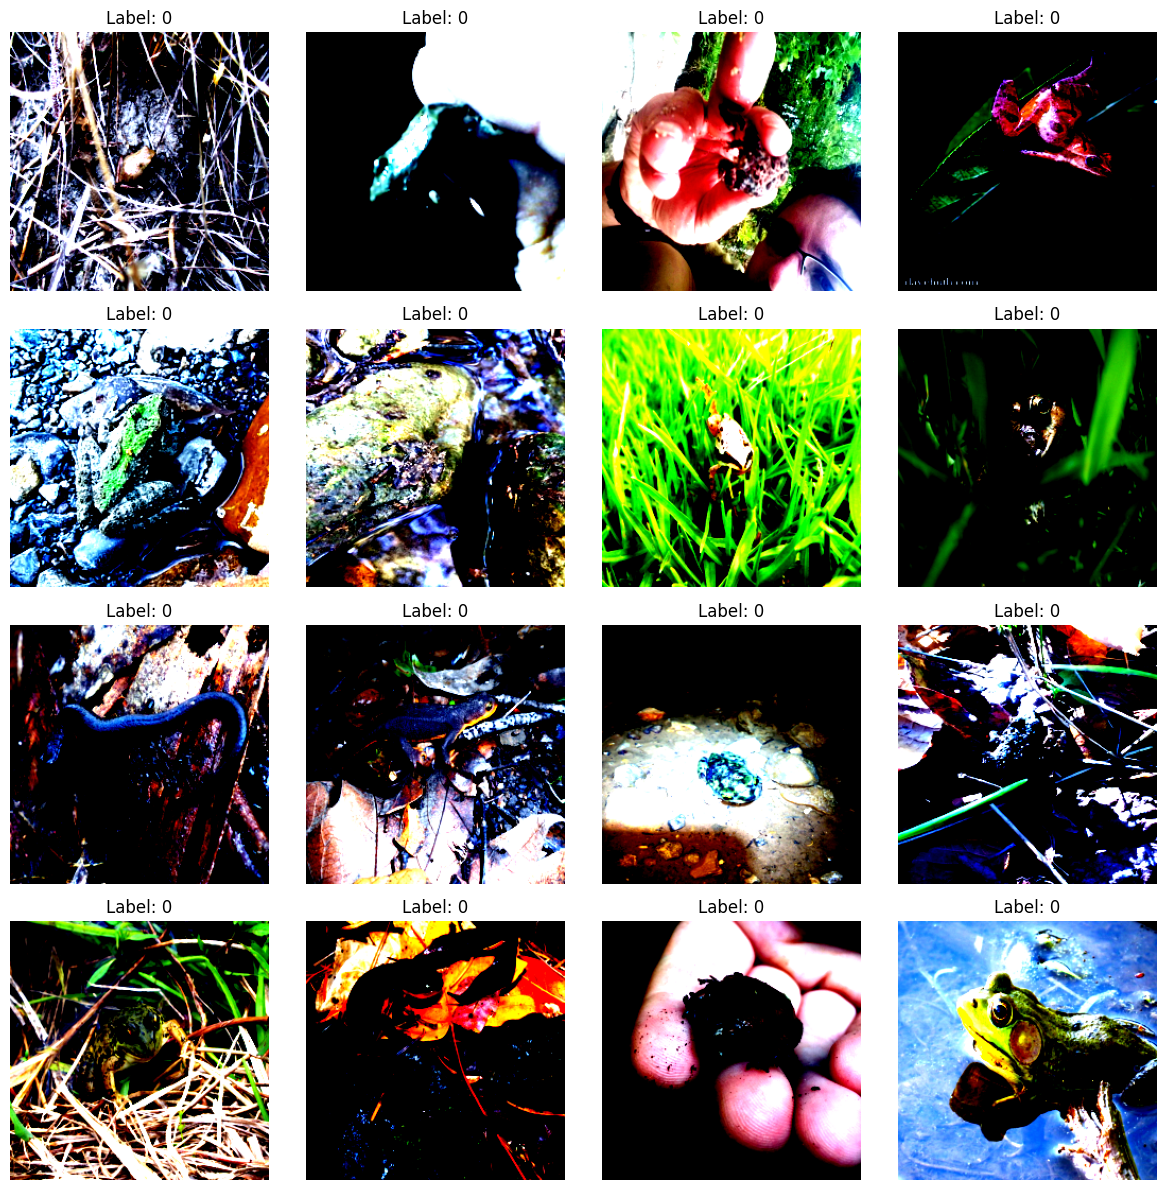

Test samples visualized for Part A
Filters visualized for Part A
Finished testing and visualization for Part A
Finished main function


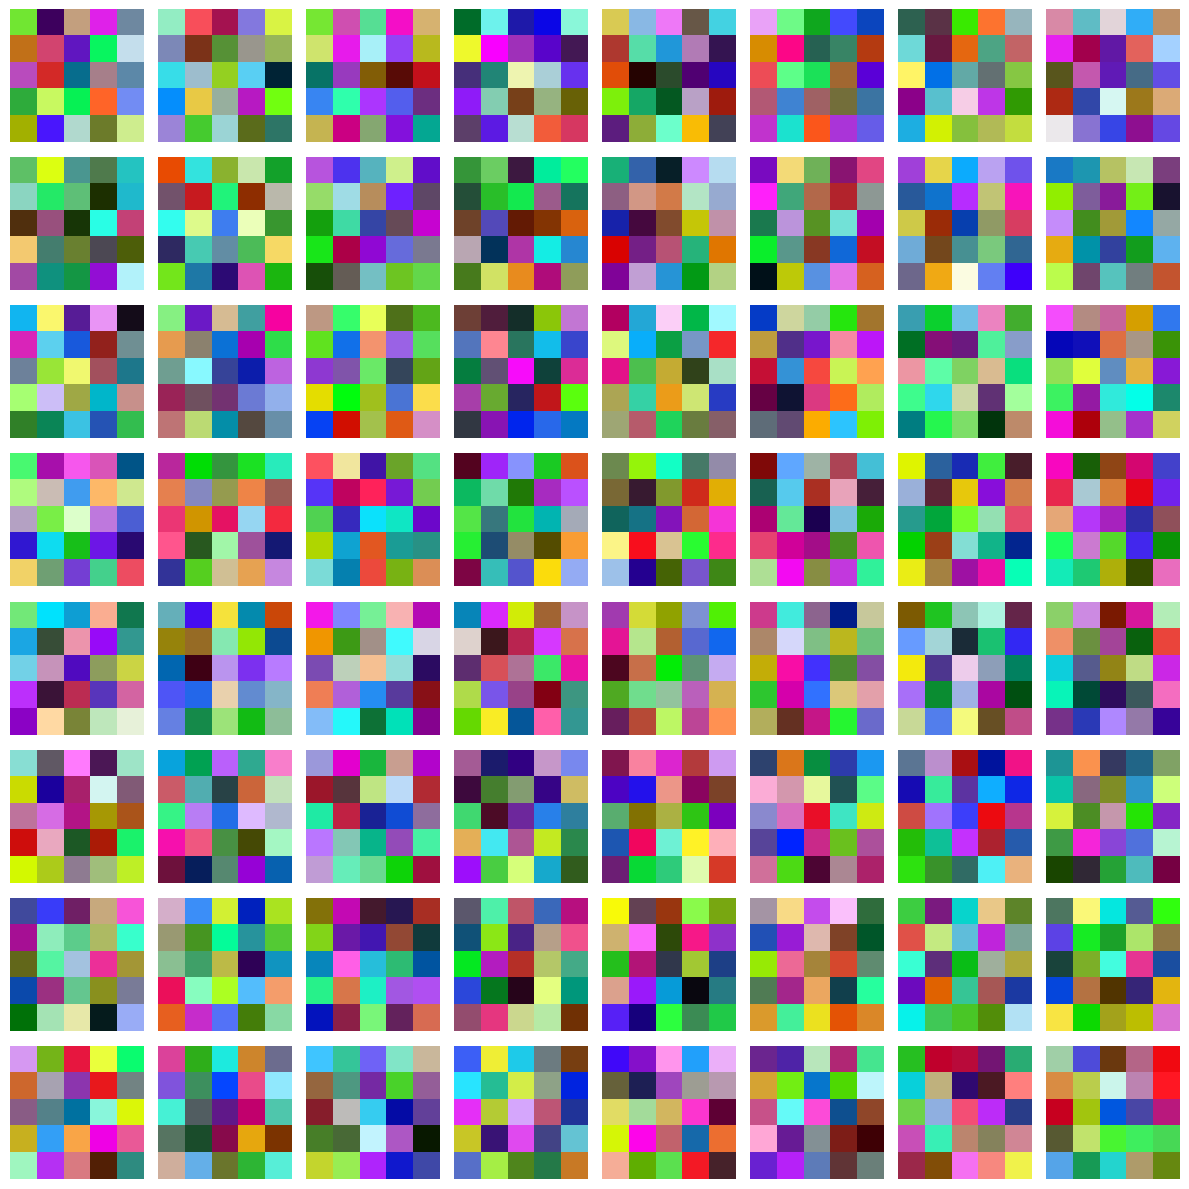

In [63]:
main(part='a', train=True, test=True)